In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import bokeh as bk
from calendar import day_name
from IPython.display import display, Markdown
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

# Analysis of stations : Visualise missing data and sample data

In [2]:
df_stations = pd.read_csv('example_sprit_cut_station.csv')



In [3]:
df_stations.head()

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,\N,49.020280,8.459429
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,\N,68169,MANNHEIM,\N,49.508962,8.467691
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,\N,49.433754,7.757465
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,\N,67655,KAISERSLAUTERN,\N,49.442200,7.748360
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,\N,76726,GERMERSHEIM,\N,49.226800,8.374400


# Analysis of stations : Clean data

We observe that there are irrelevant columns and duplicates. Moreover, invalid values need to be dealt with.

In [4]:
cols_to_drop = ['VERSION','VERSION_TIME','HOUSE_NUMBER','PUBLIC_HOLIDAY_IDENTIFIER']
# Drop irrelevant columns
df_stations.drop(cols_to_drop,inplace=True,axis=1)

In [5]:
# Drop duplicates
df_stations.drop_duplicates(inplace=True)

In [6]:
# Investigate about the null data
null_data = df_stations[df_stations.isnull().any(axis=1)]
null_data.sample(10)

,ID,NAME,BRAND,STREET,POST_CODE,PLACE,LAT,LNG
413,00060085-0002-4444-8888-acdc00000002,Autohaus Holz GmbH Neustadt,NaN,Branchweilerhofstraße,67433,Neustadt,49.351059,8.166789
40,a21e3ed2-6d03-478f-32a3-9f33202182bc,Landau,AUTO ZOTZ Landau in der Pfalz Tanken und was...,NaN,NaN,NaN,49.207778,8.135870
15,7c5aca0f-b8e4-478e-9afb-46c2c136ae4e,Globus Handelshof GmbH & Co. KG Betriebsstätt...,NaN,Merkurstr.,67663,Kaiserslautern,49.441270,7.710134
17,8e04a261-815f-43f8-a5ba-20d12c5b3273,Globus Handelshof GmbH & Co. KG Betriebsstätt...,NaN,Frankenthaler Str.,67240,Bobenheim-Roxheim,49.587580,8.355910
16,ba10c89e-d2f8-46d9-8ec5-6060bc32e89a,Globus Handelshof GmbH & Co. KG Betriebsstätte...,NaN,Daimlerstr.,67269,Grünstadt,49.557630,8.182250
11,2b690d89-9d37-4e3a-aebb-7de05f06139e,Oel-Huff GmbH Stefan Rudolph,NaN,Weinstraße,67480,Edenkoben,49.278330,8.119580
56,00060562-0001-4444-8888-acdc00000001,Tankcenter Ziehl,NaN,Carl-Benz Str.,67227,Frankenthal,49.543491,8.336738
14,400ce1d0-e095-47dd-a0fc-6073edd7c8d2,Globus Handelshof GmbH & Co.KG Betriebsstätte ...,NaN,Oderstraße,67061,Ludwigshafen-Oggersheim,49.486640,8.349300
597,e69a923a-ba11-409b-2720-2b908ed66498,Auto Zotz TK Herxheim,AUTO ZOTZ Herxheim b.LD. Tanken an L.493,NaN,NaN,NaN,49.150275,8.232815
13,698f398d-bd57-4684-be70-ea76c2cbf491,Dudenhöffer & Rung GmbH,NaN,Am Kleinwald,76863,Herxheim,49.138500,8.230990


In [7]:
# Replace Invalid Streets and Places
df_stations.update(df_stations[['STREET','PLACE']].fillna('Unknown'))

In [8]:
# Replace invalid entries in postcode
df_stations['POST_CODE'].fillna(value=0, inplace=True)
df_stations['POST_CODE'].replace(to_replace=['\\N'],value='0',inplace=True)
df_stations['POST_CODE'].replace(to_replace=['nicht'],value='0',inplace=True)

In [9]:
# Drop invalid brands
inactive_brands=df_stations[df_stations['BRAND']=='nicht mehr aktiv']
df_stations.drop(inactive_brands.index,axis=0,inplace=True)

In [10]:
# Replace NaN s and \\N s in brands
df_stations['BRAND'].fillna(value='No Brand', inplace= True)
df_stations['BRAND'].replace(to_replace=['\\N'],value='No Brand',inplace=True)

In [11]:
# Put brands and names in title case
df_stations['BRAND'] = df_stations['BRAND'].str.title()
df_stations['NAME'] = df_stations['NAME'].str.title()
#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz Herxheim B.Ld.       Tanken An L.493', 'Auto Zotz Landau In Der Pfalz   Tanken Und Waschen', 'Avia', 'Bft', 'Classic', 'E Center', 'Eberhardt Jöhlingen', 'Ed', 'Elan', 'Esso', 'Frei', 'Freie', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'No Brand', 'Oil!', 'Omv', 'Preis', 'Raiffeisen', 'Raiffeisen Tankstelle', 'Rnt', 'Sb', 'Sb Markt', 'Sb-Markttankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Shell', 'Supermarkt Tankstelle', 'Supermarkt-Tankstelle', 'Supermarkt-Tankstelle Am Real- Markt', 'T', 'Tamoil', 'Tankcenter', 'Tankhof Iffezheim', 'Tankstelle Heinz', 'Top', 'Total', 'Ts Arnt', 'Winkler', 'Zg Raiffeisen Energie']


In [12]:
# More brand cleaning
df_stations.replace({'BRAND' : { '^Auto Zotz.*' : 'Auto Zotz', 
                                           '^Frei.*' : 'Freie Tankstelle',
                                           '^Raiffeisen.*' : 'Raiffeisen Tankstelle',
                                           '^Sb.*' : 'Sb Markt Tankstelle',
                                           '^Supermarkt.*' : 'Supermarkt Tankstelle'
                                            }},regex=True,inplace=True)
#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz', 'Avia', 'Bft', 'Classic', 'E Center', 'Eberhardt Jöhlingen', 'Ed', 'Elan', 'Esso', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'No Brand', 'Oil!', 'Omv', 'Preis', 'Raiffeisen Tankstelle', 'Rnt', 'Sb Markt Tankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Shell', 'Supermarkt Tankstelle', 'T', 'Tamoil', 'Tankcenter', 'Tankhof Iffezheim', 'Tankstelle Heinz', 'Top', 'Total', 'Ts Arnt', 'Winkler', 'Zg Raiffeisen Energie']


In [13]:
# 'No name' brand can be replaced by names
df_stations['BRAND']=np.where(df_stations['BRAND']== 'No Brand', df_stations['NAME'], df_stations['BRAND'])

#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz', 'Autohaus Holz Gmbh Landau', 'Autohaus Holz Gmbh Neustadt', 'Avia', 'Bft', 'Classic', 'Dudenhöffer & Rung Gmbh', 'E Center', 'Eberhardt Hardeckstraße Karlsruhe', 'Eberhardt Jöhlingen', 'Eberhardt Rastatter Straße Karlsruhe', 'Ed', 'Elan', 'Esso', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Globus Handelshof Gmbh & Co. Kg  Betriebsstätte Bobenheim-Roxheim', 'Globus Handelshof Gmbh & Co. Kg  Betriebsstätte Kaiserslautern', 'Globus Handelshof Gmbh & Co. Kg Betriebsstätte Grünstadt', 'Globus Handelshof Gmbh & Co. Kg Betriebsstätte Neustadt', 'Globus Handelshof Gmbh & Co.Kg Betriebsstätte Ludwigshafen-Oggersheim', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'Oel-Huff Gmbh Stefan Rudolph', 'Oil!', 'Omv', 'Preis', 'Raiffeisen Tankstelle', 'Rnt', 'Sb Markt Tankstelle', 'Sbk - Tankstelle', 'Sbk Selbstbedienungskauf Gmbh Tankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Sh

In [14]:
# Even more brand cleaning
df_stations.replace({'BRAND' : { '^Autohaus Holz.*' : 'Autohaus Holz', 
                                           '^Eberhardt.*' : 'Eberhardt',
                                           '^Globus Handelshof .*' : 'Globus Handelshof Gmbh & Co. Kg',
                                           '^Sbk .*' : 'Sbk - Tankstelle',
                                            }},regex=True,inplace=True)
#Visualise unique brands
print(sorted(df_stations.BRAND.unique()))

['Agip', 'Aral', 'Auto Zotz', 'Autohaus Holz', 'Avia', 'Bft', 'Classic', 'Dudenhöffer & Rung Gmbh', 'E Center', 'Eberhardt', 'Ed', 'Elan', 'Esso', 'Freie Tankstelle', 'Fritz Walter Gmbh', 'Frühmesser Gmbh', 'Globus Handelshof Gmbh & Co. Kg', 'Hem', 'Jet', 'Markant', 'Markenfreie Ts', 'Mr. Wash Autoservice Ag', 'Mtb', 'Oel-Huff Gmbh Stefan Rudolph', 'Oil!', 'Omv', 'Preis', 'Raiffeisen Tankstelle', 'Rnt', 'Sb Markt Tankstelle', 'Sbk - Tankstelle', 'Schiffer & Nicklaus Gmbh', 'Schuster & Sohn Kg', 'Sefrin Heizöl & Kraftstoffe', 'Shell', 'Supermarkt Tankstelle', 'T', 'Tamoil', 'Tankcenter', 'Tankcenter Ziehl', 'Tankhof Iffezheim', 'Tankstelle Heinz', 'Top', 'Total', 'Ts Arnt', 'Winkler', 'Zg Raiffeisen Energie']


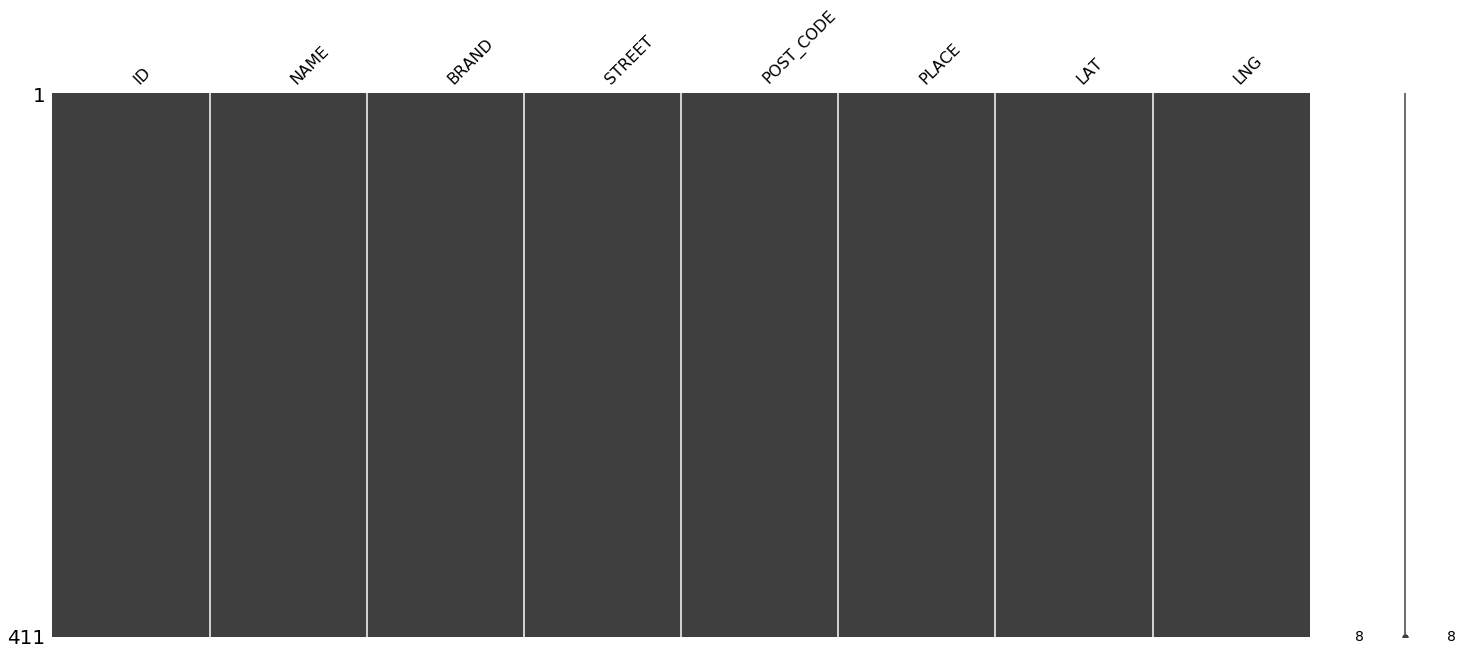

In [15]:
# Visualise number of missing entries
msno.matrix(df_stations);

# Analysis of prices: Visualise missing data and sample data

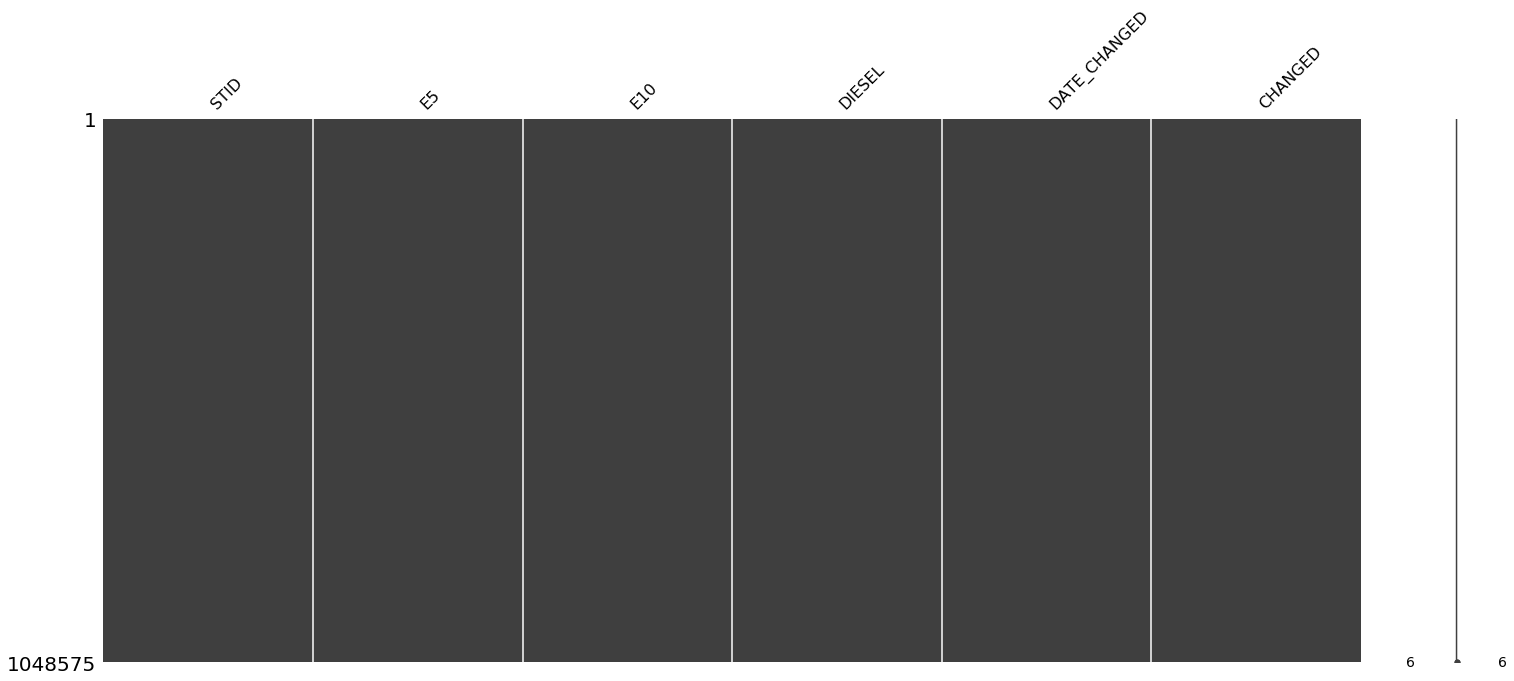

In [16]:
df_prices = pd.read_csv('example_sprit_cut_prices.csv')
# Visualise number of missing entries
msno.matrix(df_prices);

In [17]:
df_prices.sample(10)

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
386388,e0b19675-dfe9-45d4-9af0-59390cd39c09,1599,1559,1379,2014-07-02 08:30:01.000000,21
86243,829e21c1-62cf-4f9b-bbb8-abe602153e05,1669,1629,1499,2014-08-10 21:02:01.000000,21
822708,fa9f33fa-732a-4722-85da-e46eba880c1b,1699,1659,1499,2014-06-26 17:10:01.000000,21
622377,2cf7753d-b6e8-4d41-95c3-8038e19a0e65,1489,1449,1329,2014-10-23 05:42:01.000000,20
895038,8af1a656-418f-4b9a-b2a5-e0d6aab41d08,1489,1469,1179,2015-07-28 12:02:01.000000,21
760944,9e737970-c96e-4471-b0a2-b992f9a67666,1569,1529,1379,2014-08-01 01:30:01.000000,21
671171,c50bdb16-49e8-4e9a-bf1c-ae44f562dd5e,1609,1569,1369,2014-07-14 02:18:01.000000,21
342724,cc20788d-eeef-48e2-bd97-0b55926c4c48,1429,1389,1249,2014-12-05 21:17:00.000000,21
475299,5c7bdc24-f414-42b9-a1da-d00fd9493f1a,1429,1389,1259,2014-12-02 11:13:00.000000,21
553569,a6fdf6e7-d225-49b1-95a6-9465c4f3a980,1519,1499,1219,2015-08-03 22:38:01.000000,21


# Analysis of prices : Clean data
We see that there are invalid prices along with duplicates. We need to normalise the dataset firstly and then perform the analysis

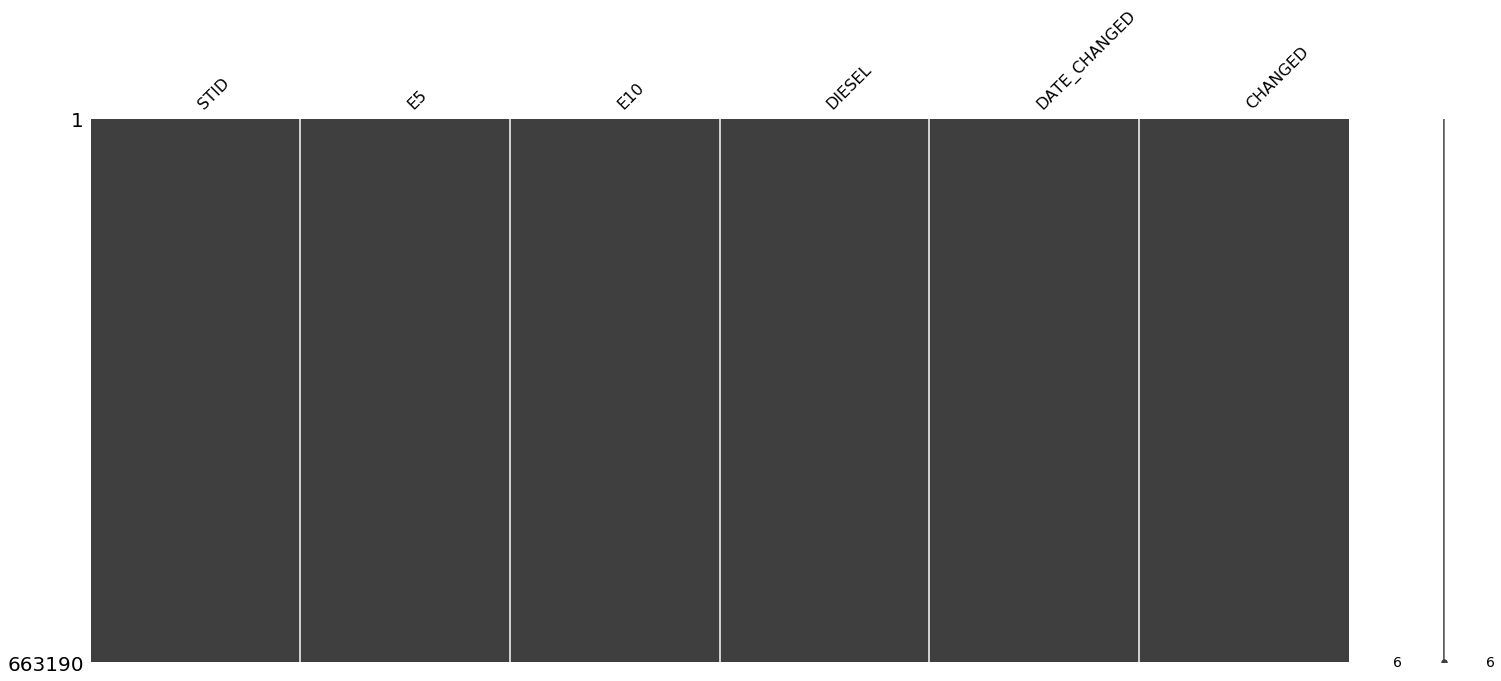

In [18]:
# Drop duplicates
df_prices.drop_duplicates(inplace=True)
msno.matrix(df_prices);

In [19]:
e5_invalid=df_prices[df_prices['E5']<=0]
e5_invalid.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
1666,9aab1ae8-c032-4834-bee4-bb0227ec4e3f,0,0,1319,2014-12-14 22:02:01.000000,1
1667,9aab1ae8-c032-4834-bee4-bb0227ec4e3f,0,0,1269,2014-12-15 05:26:01.000000,1
1668,9aab1ae8-c032-4834-bee4-bb0227ec4e3f,0,0,1249,2014-12-15 06:06:01.000000,1
1669,9aab1ae8-c032-4834-bee4-bb0227ec4e3f,0,0,1259,2014-12-16 05:26:01.000000,1
1670,9aab1ae8-c032-4834-bee4-bb0227ec4e3f,0,0,1239,2014-12-16 06:06:01.000000,1


In [20]:
# Remove invalid prices from the data
def remove_invalid_prices(fuel_name):
    fuel_invalid=df_prices[df_prices[fuel_name]<=0]
    df_prices.drop(fuel_invalid.index,axis=0,inplace=True)

remove_invalid_prices('E5')
remove_invalid_prices('E10')
remove_invalid_prices('DIESEL')

In [21]:
df_prices.describe()

,E5,E10,DIESEL,CHANGED
count,652627.000000,652627.000000,652627.000000,652627.000000
mean,1456.175020,1428.300564,1246.422744,18.974217
std,105.081748,100.668528,104.504047,7.667888
min,8.000000,1009.000000,999.000000,1.000000
25%,1379.000000,1359.000000,1169.000000,21.000000
50%,1459.000000,1429.000000,1229.000000,21.000000
75%,1529.000000,1499.000000,1319.000000,21.000000
max,9999.000000,9999.000000,11290.000000,63.000000


We see that the max, min are quite unrealistically bad. This needs normalisation

In [22]:
def normalise_data(fuel_name):
    data_mean, data_std = df_prices[fuel_name].mean(), df_prices[fuel_name].std()
    # identify outliers upto 3 standard deviations
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    df_prices[fuel_name]=np.where(np.logical_or(df_prices[fuel_name] <
                                                lower,df_prices[fuel_name] > upper), 
                                  df_prices[fuel_name].median(), 
                                  df_prices[fuel_name])

normalise_data('E5')
normalise_data('E10')
normalise_data('DIESEL')

In [23]:
df_prices.describe()

,E5,E10,DIESEL,CHANGED
count,652627.000000,652627.000000,652627.000000,652627.000000
mean,1456.070584,1428.205519,1246.295952,18.974217
std,101.107786,96.938320,99.521542,7.667888
min,1148.000000,1129.000000,999.000000,1.000000
25%,1379.000000,1359.000000,1169.000000,21.000000
50%,1459.000000,1429.000000,1229.000000,21.000000
75%,1529.000000,1499.000000,1319.000000,21.000000
max,1759.000000,1729.000000,1549.000000,63.000000


In [24]:
# # Replace fuel prices to euro
# for fuel in ('E5','E10','DIESEL'):
#     df_prices[fuel] = df_prices[fuel]/1000

# Save dates in standard format
df_prices['DATE_CHANGED'] = pd.to_datetime(df_prices['DATE_CHANGED'])

In [25]:
df_stations.rename(columns={'ID':'STID'}, inplace=True)
merged_df= pd.merge(df_prices,df_stations, on='STID')
print(merged_df)


                                        STID      E5     E10  DIESEL  \
0       01bf5a06-4248-43a5-9524-56123fa3ab2f  1589.0  1549.0  1389.0   
1       01bf5a06-4248-43a5-9524-56123fa3ab2f  1569.0  1529.0  1369.0   
2       01bf5a06-4248-43a5-9524-56123fa3ab2f  1569.0  1529.0  1359.0   
3       01bf5a06-4248-43a5-9524-56123fa3ab2f  1539.0  1499.0  1339.0   
4       01bf5a06-4248-43a5-9524-56123fa3ab2f  1529.0  1489.0  1329.0   
5       01bf5a06-4248-43a5-9524-56123fa3ab2f  1629.0  1589.0  1429.0   
6       01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0  1389.0   
7       01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0  1379.0   
8       01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0  1339.0   
9       01bf5a06-4248-43a5-9524-56123fa3ab2f  1559.0  1519.0  1309.0   
10      01bf5a06-4248-43a5-9524-56123fa3ab2f  1559.0  1519.0  1299.0   
11      01bf5a06-4248-43a5-9524-56123fa3ab2f  1529.0  1489.0  1299.0   
12      01bf5a06-4248-43a5-9524-56123fa3ab2f  1619.0  1579.0  14

In [26]:
# We assume brand history in the specified data is the existing history
brand_existence = merged_df.groupby('STID')['NAME','DATE_CHANGED']
brand_start=brand_existence.min().reset_index()
brand_end=brand_existence.max().reset_index()
# get brand history in days and 
brand_history = (pd.to_datetime(brand_end['DATE_CHANGED'])-pd.to_datetime(brand_start['DATE_CHANGED'])).dt.days
brand_end['No of Days'] = brand_history

In [27]:
brand_end

,STID,NAME,DATE_CHANGED,No of Days
0,00060385-0001-4444-8888-acdc00000001,Freie Tankstelle,2015-09-28 14:54:01,394
1,00060458-0001-4444-8888-acdc00000001,Tankhof Iffezheim,2015-09-29 13:58:01,477
2,00060562-0001-4444-8888-acdc00000001,Tankcenter Ziehl,2015-09-29 14:58:01,404
3,00060710-0001-4444-8888-acdc00000001,Sbk Selbstbedienungskauf Gmbh Tankstelle,2015-09-24 16:42:01,471
4,00060982-0001-4444-8888-acdcffffffff,Tankstelle Heinz,2015-09-29 14:30:01,406
5,00b33b42-8357-40c2-baf5-c7c49b40b2af,Aral Tankstelle,2015-09-29 20:02:01,478
6,01a94df2-5e6e-4a4a-b1f5-e2612e25a62f,Neustadt Landauerstr,2015-09-29 20:02:01,478
7,01bf5a06-4248-43a5-9524-56123fa3ab2f,Esso Tankstelle,2015-09-29 23:06:01,478
8,01ddc2f2-35ca-4a02-a47c-190ebabe558b,Winkler-Bürstadt,2015-09-28 16:30:01,355
9,033bce61-7584-45e7-94dd-952fd0b4899c,Landau Weissenburger Strass.,2015-09-29 23:34:01,478


In [28]:
brand_group = brand_end.groupby('No of Days')

In [29]:
max_idx = brand_group['STID'].count().idxmax()
max_idx

478

In [30]:
top_brand_list = (brand_group.get_group(max_idx)['STID'][:100]).to_list()


In [31]:
(brand_group.get_group(max_idx)['STID'][:100]).values

array(['00b33b42-8357-40c2-baf5-c7c49b40b2af',
       '01a94df2-5e6e-4a4a-b1f5-e2612e25a62f',
       '01bf5a06-4248-43a5-9524-56123fa3ab2f',
       '033bce61-7584-45e7-94dd-952fd0b4899c',
       '061716a5-f4a6-4983-a36e-8ef1e8ce17e0',
       '07a543ee-7e3c-4620-a03d-fe60d0d3ba71',
       '09839b72-1976-4e20-b617-acccecf75ea0',
       '0a04c648-965f-45b0-9470-b05db049ed70',
       '0b49934c-1119-424a-b833-aba72e465c8e',
       '0d206f86-308b-43ae-a157-b7e625bdf61b',
       '0d7b12a6-df95-4e49-b9c4-bf40bbb2c726',
       '0e083aea-4678-4003-bd43-6f50bda36dc5',
       '0e31a3fd-c450-4a29-923d-70343d7b1883',
       '0f04312e-a784-4dfa-b30f-74d203f6bfb7',
       '0f2e0c50-51c1-4a4f-bfdb-c6f2eb676893',
       '1377d893-cf53-4dd4-9672-be46ec770f9d',
       '14ec4b5b-18f3-4664-b768-1958f9e3b49f',
       '157d9fc7-d567-45a9-94ec-6bced00532ca',
       '16c7cc25-cfdf-4e18-81b3-90d7f17f35fe',
       '17ac8e20-e554-4819-873d-0e6776201823',
       '1921dcf2-68c9-440a-ab46-4f5c60e6042a',
       '1a4e6

In [32]:
merged_df_top20 = merged_df[merged_df.STID.isin(top_brand_list)]

In [33]:
print(merged_df_top20)

                                        STID      E5     E10  DIESEL  \
0       01bf5a06-4248-43a5-9524-56123fa3ab2f  1589.0  1549.0  1389.0   
1       01bf5a06-4248-43a5-9524-56123fa3ab2f  1569.0  1529.0  1369.0   
2       01bf5a06-4248-43a5-9524-56123fa3ab2f  1569.0  1529.0  1359.0   
3       01bf5a06-4248-43a5-9524-56123fa3ab2f  1539.0  1499.0  1339.0   
4       01bf5a06-4248-43a5-9524-56123fa3ab2f  1529.0  1489.0  1329.0   
5       01bf5a06-4248-43a5-9524-56123fa3ab2f  1629.0  1589.0  1429.0   
6       01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0  1389.0   
7       01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0  1379.0   
8       01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0  1339.0   
9       01bf5a06-4248-43a5-9524-56123fa3ab2f  1559.0  1519.0  1309.0   
10      01bf5a06-4248-43a5-9524-56123fa3ab2f  1559.0  1519.0  1299.0   
11      01bf5a06-4248-43a5-9524-56123fa3ab2f  1529.0  1489.0  1299.0   
12      01bf5a06-4248-43a5-9524-56123fa3ab2f  1619.0  1579.0  14

In [34]:
filtered_merged = merged_df_top20.drop(['CHANGED','STREET','POST_CODE','PLACE','LAT','LNG'],axis=1)

In [35]:
filtered_merged = filtered_merged.set_index('DATE_CHANGED')
top_20_between_12_13 = filtered_merged.between_time('07:00', '20:00')



In [36]:
print(top_20_between_12_13)

                                                     STID      E5     E10  \
DATE_CHANGED                                                                
2014-10-02 09:06:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1569.0  1529.0   
2014-10-03 12:14:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1539.0  1499.0   
2014-10-03 14:14:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1529.0  1489.0   
2014-10-06 07:38:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0   
2014-10-06 08:26:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1549.0  1509.0   
2014-10-07 07:38:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1559.0  1519.0   
2014-10-07 10:18:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1559.0  1519.0   
2014-10-07 10:22:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1529.0  1489.0   
2014-10-13 11:34:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1509.0  1469.0   
2014-10-14 12:14:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1519.0  1479.0   
2014-10-14 12:18:01  01bf5a06-4248-43a5-9524-56123fa3ab2f  1509.0  1469.0   

In [37]:
stid_grouped_obj_df = top_20_between_12_13.groupby(top_20_between_12_13.index.date)['E5','E10','DIESEL'].mean()

In [38]:
top_20_between_12_13

,STID,E5,E10,DIESEL,NAME,BRAND
DATE_CHANGED,,,,,,
2014-10-02 09:06:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569.0,1529.0,1359.0,Esso Tankstelle,Esso
2014-10-03 12:14:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1539.0,1499.0,1339.0,Esso Tankstelle,Esso
2014-10-03 14:14:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529.0,1489.0,1329.0,Esso Tankstelle,Esso
2014-10-06 07:38:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1549.0,1509.0,1379.0,Esso Tankstelle,Esso
2014-10-06 08:26:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1549.0,1509.0,1339.0,Esso Tankstelle,Esso
2014-10-07 07:38:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1559.0,1519.0,1309.0,Esso Tankstelle,Esso
2014-10-07 10:18:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1559.0,1519.0,1299.0,Esso Tankstelle,Esso
2014-10-07 10:22:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529.0,1489.0,1299.0,Esso Tankstelle,Esso
2014-10-13 11:34:01,01bf5a06-4248-43a5-9524-56123fa3ab2f,1509.0,1469.0,1309.0,Esso Tankstelle,Esso


In [39]:
type(stid_grouped_obj_df)

pandas.core.frame.DataFrame

In [40]:
#converting our dataset into series data and checking its type
stid_df_sample=stid_grouped_obj_df['E10']



In [41]:
stid_df_sample

2014-06-08    1523.210526
2014-06-09    1550.926230
2014-06-10    1534.690377
2014-06-11    1541.638037
2014-06-12    1547.055556
2014-06-13    1557.074534
2014-06-14    1567.965517
2014-06-15    1601.205882
2014-06-16    1560.393035
2014-06-17    1566.661692
2014-06-18    1548.481865
2014-06-19    1586.934783
2014-06-20    1555.443515
2014-06-21    1581.272727
2014-06-22    1592.664122
2014-06-23    1555.804979
2014-06-24    1569.751174
2014-06-25    1549.306513
2014-06-26    1563.453441
2014-06-27    1551.509881
2014-06-28    1576.256098
2014-06-29    1577.994975
2014-06-30    1557.109244
2014-07-01    1566.684729
2014-07-02    1563.500000
2014-07-03    1549.327869
2014-07-04    1561.500000
2014-07-05    1541.727273
2014-07-06    1570.205674
2014-07-07    1554.780591
                 ...     
2015-08-31    1333.818402
2015-09-01    1337.514412
2015-09-02    1336.942478
2015-09-03    1339.945055
2015-09-04    1337.421053
2015-09-05    1341.831461
2015-09-06    1342.663912
2015-09-07  

In [42]:
type(stid_df_sample)

pandas.core.series.Series

In [43]:
# Test for Stationarity to remove the autocorrelation from the dataset. We need to observe the p value.
#p value should be < 0.05 for the data to be stationary.
def stationarity_test(timeseries):
    """"Augmented Dickey-Fuller Test
    Test for Stationarity"""
    from statsmodels.tsa.stattools import adfuller
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag = "AIC")
    df_output = pd.Series(df_test[0:4],
                          index = ["Test Statistic", "p-value", "#Lags Used",
                                   "Number of Observations Used"])
    print(df_output)

In [44]:
stationarity_test(stid_df_sample)

Results of Dickey-Fuller Test:
Test Statistic                  -1.953331
p-value                          0.307403
#Lags Used                      15.000000
Number of Observations Used    463.000000
dtype: float64


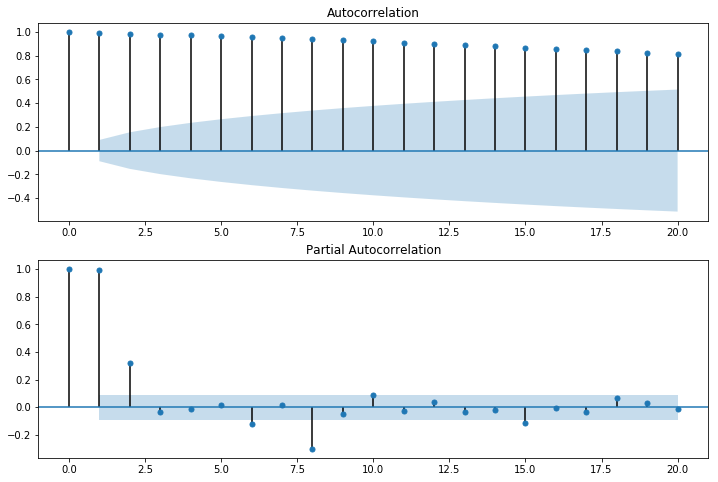

In [45]:
# Autocorrelation and partical autocorrelation- Tells us if the earlier observation influence the later observations
# Classic ACF and PACF Plots for Autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(stid_df_sample, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(stid_df_sample, lags=20, ax=ax2)

In [46]:
stid_df_sample.tail()

2015-09-25    1302.587361
2015-09-26    1305.966068
2015-09-27    1308.213759
2015-09-28    1306.504621
2015-09-29    1310.724846
Name: E10, dtype: float64

In [47]:
type(stid_df_sample)

pandas.core.series.Series

In [48]:
stid_df_sample

2014-06-08    1523.210526
2014-06-09    1550.926230
2014-06-10    1534.690377
2014-06-11    1541.638037
2014-06-12    1547.055556
2014-06-13    1557.074534
2014-06-14    1567.965517
2014-06-15    1601.205882
2014-06-16    1560.393035
2014-06-17    1566.661692
2014-06-18    1548.481865
2014-06-19    1586.934783
2014-06-20    1555.443515
2014-06-21    1581.272727
2014-06-22    1592.664122
2014-06-23    1555.804979
2014-06-24    1569.751174
2014-06-25    1549.306513
2014-06-26    1563.453441
2014-06-27    1551.509881
2014-06-28    1576.256098
2014-06-29    1577.994975
2014-06-30    1557.109244
2014-07-01    1566.684729
2014-07-02    1563.500000
2014-07-03    1549.327869
2014-07-04    1561.500000
2014-07-05    1541.727273
2014-07-06    1570.205674
2014-07-07    1554.780591
                 ...     
2015-08-31    1333.818402
2015-09-01    1337.514412
2015-09-02    1336.942478
2015-09-03    1339.945055
2015-09-04    1337.421053
2015-09-05    1341.831461
2015-09-06    1342.663912
2015-09-07  

In [49]:
# stid_grouped_obj_df["E5"]

In [50]:
X=stid_grouped_obj_df.E5.values
print(X)

[1563.21052632 1590.92622951 1574.43933054 1582.80368098 1587.05555556
 1597.07453416 1607.96551724 1641.20588235 1600.39303483 1606.66169154
 1588.53367876 1626.93478261 1595.48535565 1621.27272727 1632.66412214
 1595.80497925 1609.75117371 1589.30651341 1603.12955466 1591.50988142
 1616.25609756 1617.99497487 1597.1092437  1606.68472906 1603.40909091
 1589.28688525 1601.5        1581.72727273 1610.20567376 1594.78059072
 1600.34078212 1578.78902954 1605.04347826 1579.75812274 1606.96610169
 1611.86885246 1585.84729064 1596.47311828 1578.21428571 1580.73431734
 1568.32432432 1592.25757576 1613.16666667 1563.93449782 1579.23584906
 1547.63354037 1582.25301205 1579.         1576.04918033 1610.9266055
 1572.00492611 1575.46586345 1575.81632653 1564.73839662 1582.06220096
 1562.47826087 1604.35714286 1564.81673307 1545.4983165  1542.03797468
 1535.43229167 1533.07643312 1535.74107143 1556.7245509  1541.87096774
 1537.53125    1527.58974359 1534.22058824 1536.6534296  1528.14814815
 1541.5

In [51]:
stid_grouped_obj_df

,E5,E10,DIESEL
2014-06-08,1563.210526,1523.210526,1356.218045
2014-06-09,1590.926230,1550.926230,1385.434426
2014-06-10,1574.439331,1534.690377,1369.000000
2014-06-11,1582.803681,1541.638037,1368.877301
2014-06-12,1587.055556,1547.055556,1378.722222
2014-06-13,1597.074534,1557.074534,1384.341615
2014-06-14,1607.965517,1567.965517,1395.149425
2014-06-15,1641.205882,1601.205882,1429.220588
2014-06-16,1600.393035,1560.393035,1388.900498
2014-06-17,1606.661692,1566.661692,1397.855721


In [52]:
def plot_rolling(timeseries, window):
    rol_mean = timeseries.rolling(window).mean()
    rol_std = timeseries.rolling(window).std()
    
    fig = plt.figure(figsize = (12, 8))
    og = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rol_mean, color = "red", label = "Rolling Mean")
    std = plt.plot(rol_std, color = "black", label = "Rolling Std")
    plt.legend(loc = "best")
    plt.title("Rolling Mean and Standard Deviation (window = "+str(window)+")")
    plt.show()

In [53]:
training_df, testing_df = np.split(stid_grouped_obj_df, [int((2/3)*len(stid_grouped_obj_df))])

In [54]:
# testing_df- 2015-04-23 2015-09-29

In [55]:
training_df.index.values

array([datetime.date(2014, 6, 8), datetime.date(2014, 6, 9),
       datetime.date(2014, 6, 10), datetime.date(2014, 6, 11),
       datetime.date(2014, 6, 12), datetime.date(2014, 6, 13),
       datetime.date(2014, 6, 14), datetime.date(2014, 6, 15),
       datetime.date(2014, 6, 16), datetime.date(2014, 6, 17),
       datetime.date(2014, 6, 18), datetime.date(2014, 6, 19),
       datetime.date(2014, 6, 20), datetime.date(2014, 6, 21),
       datetime.date(2014, 6, 22), datetime.date(2014, 6, 23),
       datetime.date(2014, 6, 24), datetime.date(2014, 6, 25),
       datetime.date(2014, 6, 26), datetime.date(2014, 6, 27),
       datetime.date(2014, 6, 28), datetime.date(2014, 6, 29),
       datetime.date(2014, 6, 30), datetime.date(2014, 7, 1),
       datetime.date(2014, 7, 2), datetime.date(2014, 7, 3),
       datetime.date(2014, 7, 4), datetime.date(2014, 7, 5),
       datetime.date(2014, 7, 6), datetime.date(2014, 7, 7),
       datetime.date(2014, 7, 8), datetime.date(2014, 7, 9),
   

In [56]:
training_df.index.values

array([datetime.date(2014, 6, 8), datetime.date(2014, 6, 9),
       datetime.date(2014, 6, 10), datetime.date(2014, 6, 11),
       datetime.date(2014, 6, 12), datetime.date(2014, 6, 13),
       datetime.date(2014, 6, 14), datetime.date(2014, 6, 15),
       datetime.date(2014, 6, 16), datetime.date(2014, 6, 17),
       datetime.date(2014, 6, 18), datetime.date(2014, 6, 19),
       datetime.date(2014, 6, 20), datetime.date(2014, 6, 21),
       datetime.date(2014, 6, 22), datetime.date(2014, 6, 23),
       datetime.date(2014, 6, 24), datetime.date(2014, 6, 25),
       datetime.date(2014, 6, 26), datetime.date(2014, 6, 27),
       datetime.date(2014, 6, 28), datetime.date(2014, 6, 29),
       datetime.date(2014, 6, 30), datetime.date(2014, 7, 1),
       datetime.date(2014, 7, 2), datetime.date(2014, 7, 3),
       datetime.date(2014, 7, 4), datetime.date(2014, 7, 5),
       datetime.date(2014, 7, 6), datetime.date(2014, 7, 7),
       datetime.date(2014, 7, 8), datetime.date(2014, 7, 9),
   

In [57]:
def mean_abs_deviation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mean_values(data):
    return data.mean()

The Optimal window size E5 for the training is :26
The Optimal window size E10 for the training is :314
The Optimal window size DIESEL for the training is :3


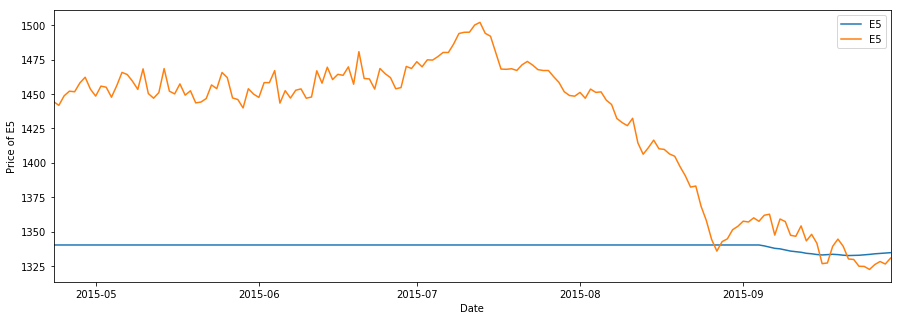

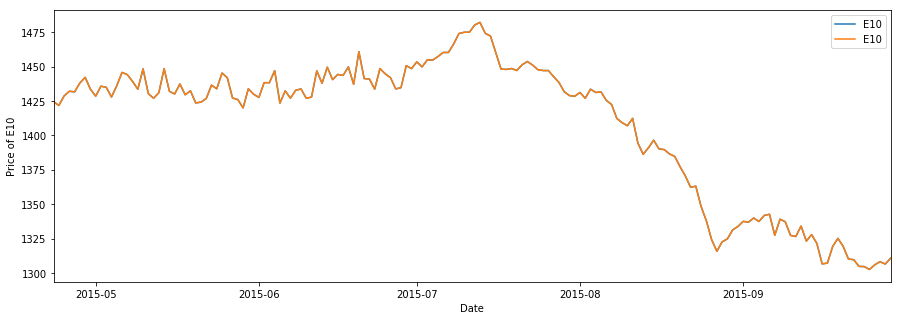

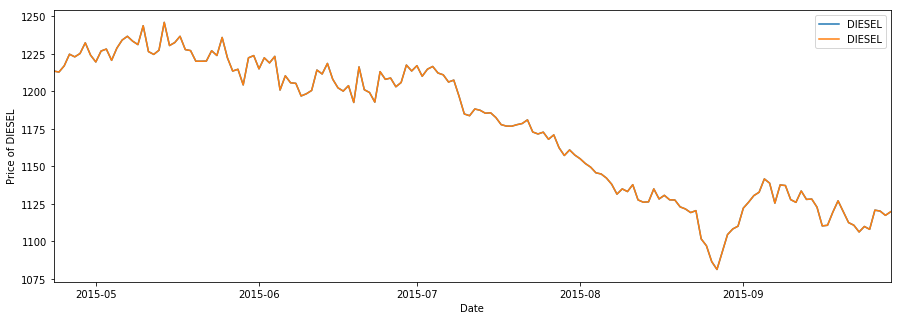

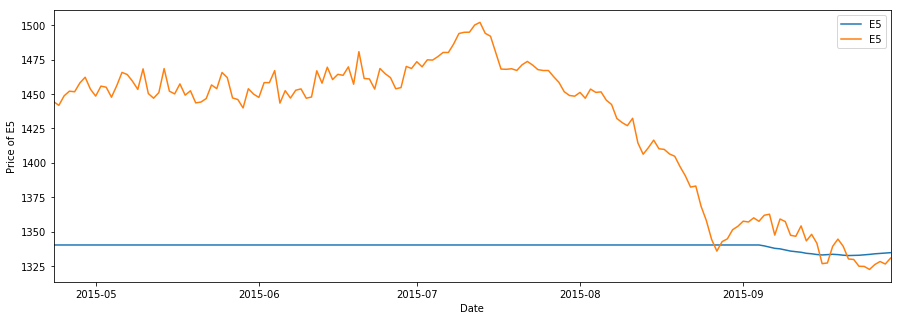

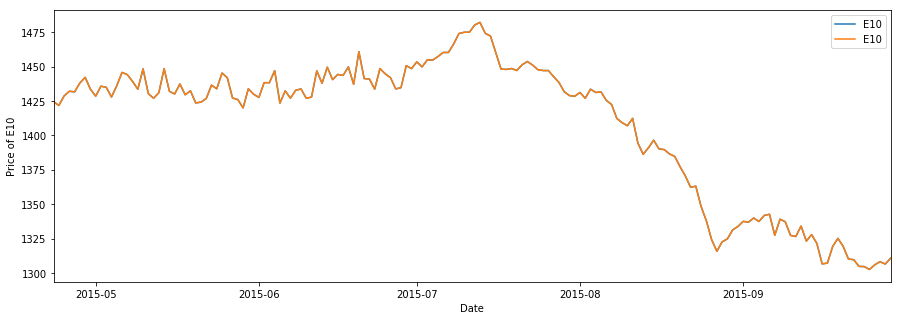

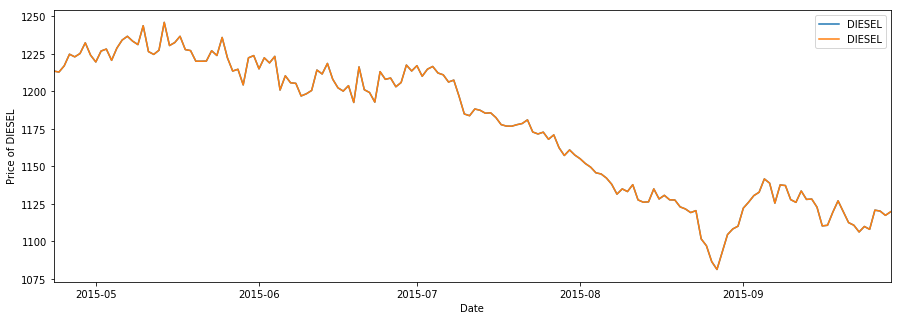

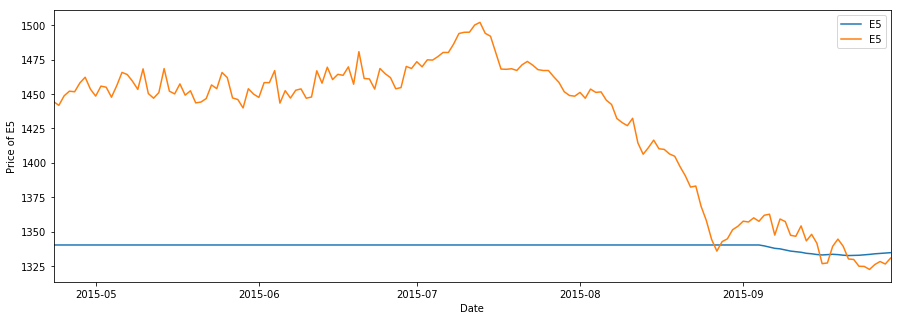

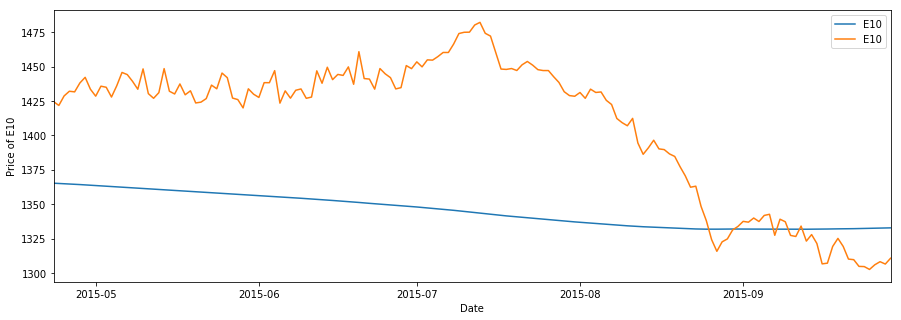

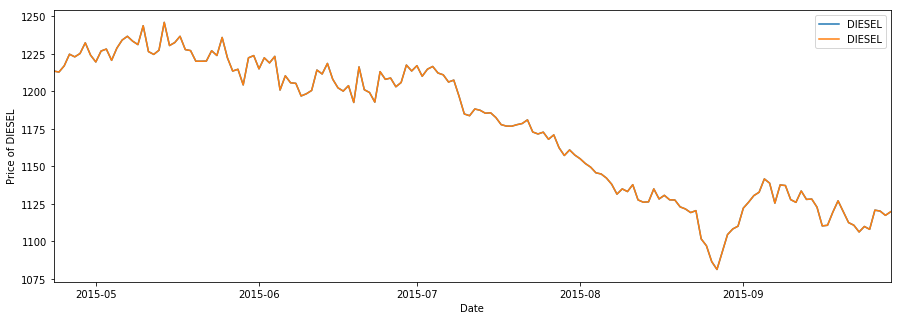

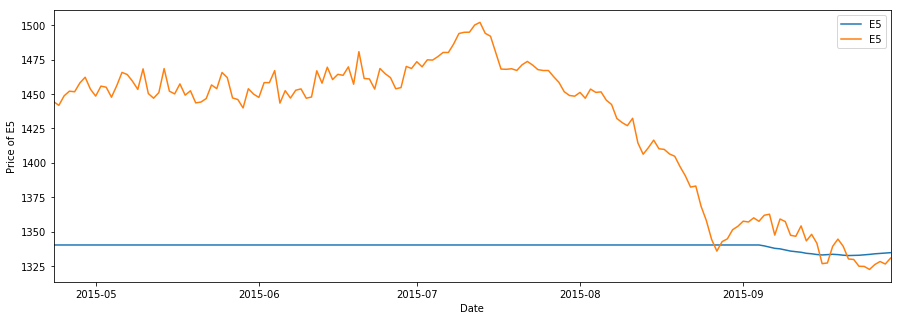

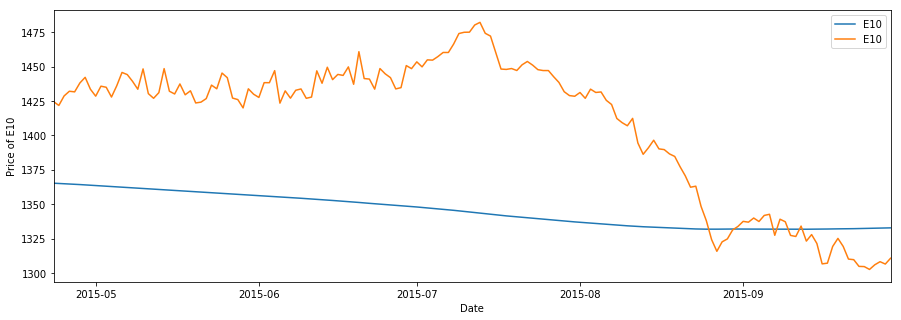

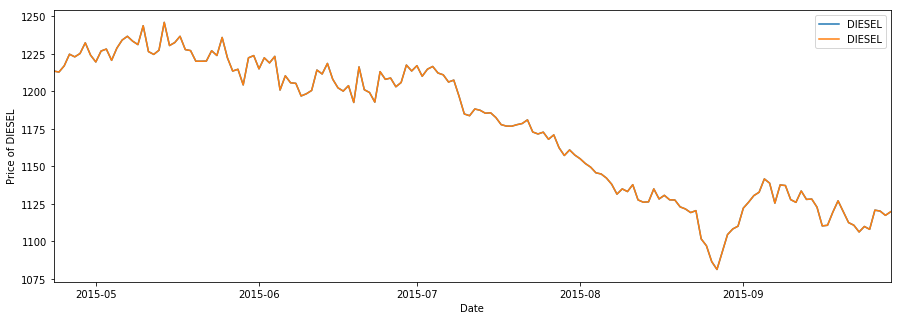

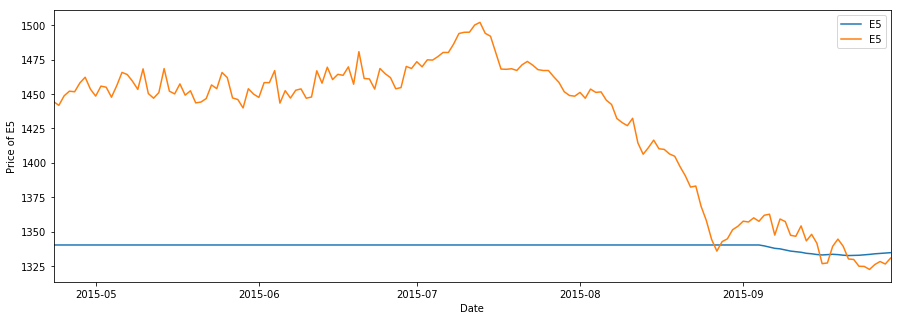

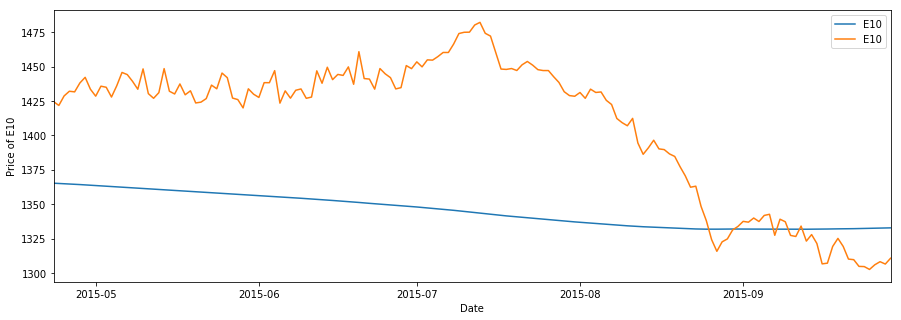

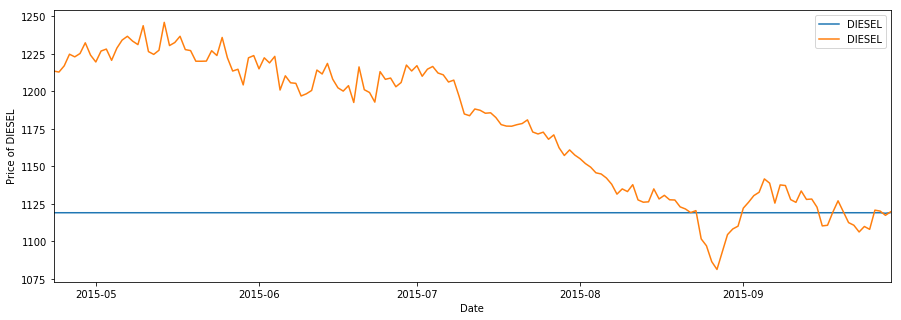

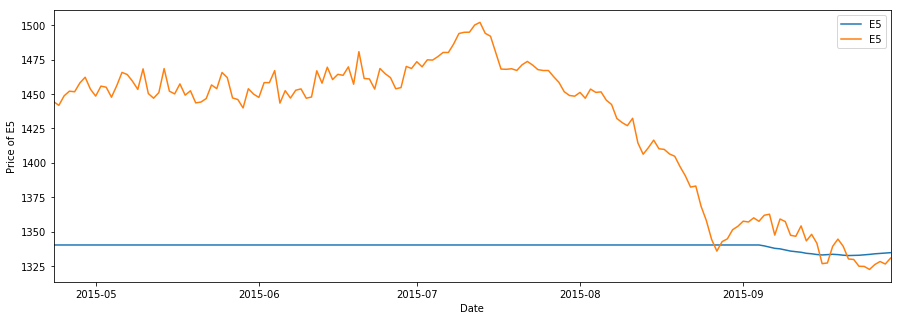

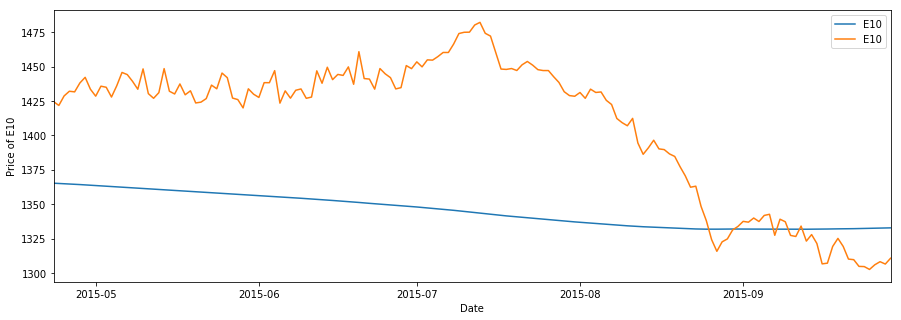

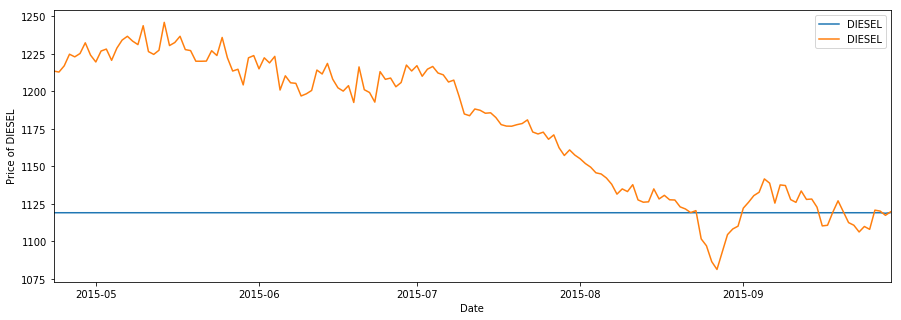

In [58]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
df_copy=stid_grouped_obj_df.copy()
for i in ['E5','E10','DIESEL']:
    X=training_df.index.values
    y= training_df[i].values
    num_values = len(training_df.index.values)
    tscv = TimeSeriesSplit(n_splits=num_values-1)
    AVG_overall=[]

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        #     print("TRAIN:", X_train, "TEST:", X_test)
        y_train, y_test = y[train_index], y[test_index]
        # print("TRAIN:", y_train, "TEST:", y_test)
        win_size = len(train_index)
#         print ('The current window size is '+str(win_size))
        moving_avg=training_df[i].rolling(window=win_size).mean()
        Shifted_moving=moving_avg.shift(1)
#         print (X_test)
        Shifted_rolling=pd.DataFrame(Shifted_moving[X_test].values, columns=["y_hat"])
#         print(Shifted_rolling)
#         Shifted_rolling['y_hat']=Shifted_moving[X_test]
        Shifted_rolling['y']=y_test
#         print(Shifted_rolling)

        mad_mean=Shifted_rolling.mad(axis=1).values[-1]
#         print("MAD value: " +str(mad_mean))
#         print(type(mad_mean))
        MAPE_avg= np.mean(np.abs((y_test - Shifted_moving[X_test].values.item()) / y_test)) * 100
#         print("MAPE value: " +str(MAPE_avg))
        AVG_overall.append((mad_mean+MAPE_avg)/2)
#         print("Over all average:" +str(AVG_overall))
        
        
    Optima_window_size=AVG_overall.index(min(AVG_overall))+1
    print("The Optimal window size "+str(i)+" for the training is :"+str(Optima_window_size))
    
    for j in testing_df[i].index:
        moving_avg_test=df_copy[i].rolling(window=Optima_window_size).mean()
        df_copy[i][j]=moving_avg_test.values[-1]


    mask = (df_copy.index >= testing_df.index[0]) & (df_copy.index <= testing_df.index[-1])
    frame= df_copy.loc[mask]
    frame = pd.concat([frame, testing_df], axis= 1)
    for fuel in frame:
#         print(frame[fuel].values[0][0])
        mad_test=frame[fuel].mad(axis=1).values
        MAPE_avg= np.mean(np.abs(( frame[fuel].values[0][0]/ frame[fuel].values[0][1])) * 100)
        p = frame[fuel].plot(figsize=(15, 5))
        plt.xlabel('Date')
        plt.ylabel('Price of '+fuel) 
        
    
   


# Modeling using Facebook Prophet

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [60]:
training_df = np.split(training_df, np.arange(len(training_df.columns)), axis=1)
testing_df = np.split(testing_df, np.arange(len(testing_df.columns)), axis=1)
training_sets = []

for i,j in enumerate(range(1,4)):
    fuel_type = (training_df[j].columns.values.item())
    fuel_copy = training_df[j].copy()
    
    fuel_copy.reset_index(level=0, inplace=True)
   
    fuel_copy.columns = ['ds' , 'y']
    training_sets.append(fuel_copy)


In [61]:
prophets = []
for training_set in training_sets:
    # Create Prophet with seasonality in week, year and half year
    m = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
    m.fit(training_set)
    prophets.append(m)
    

In [62]:
testing_dates = (testing_df[0].index.values)
first_day_test = testing_dates[0]
last_day_test = testing_dates[-1]
num_days_to_test = (last_day_test-first_day_test).days

num_days_to_test += 1
futures = []
for prophet in prophets:
    futures.append(m.make_future_dataframe(periods=num_days_to_test))

In [63]:
pd.plotting.register_matplotlib_converters()

 #Comparing simple average model and Prophet model¶

In [ ]:

fuels = training_df.columns


forecasts = []
for fuel,prophet, future in zip(fuels,prophets, futures):
    forecast = prophet.predict(future)
    #forecasts.append(forecast[['ds','yhat']])
    #print(forecast)
    g = prophet.plot(forecast)

    plt.title('Prediction of price of '+fuel)
    plt.xlabel('Date')
    plt.ylabel('Price of '+fuel)

In [ ]:
for enum_i, fuel in enumerate(['E5','E10','DIESEL']):
    mad_pairs_list=([[frame[fuel].values[i][0],frame[fuel].values[i][1]] for i in range(len(frame.index.values))])
    mad_list = [mean_abs_deviation(x,y) for x,y in mad_pairs_list]
    
    mad_pairs_prophet= ([[forecasts[enum_i]['yhat'][i],frame[fuel].values[i][1]] for i in range(len(frame.index.values))])
    mad_list_prophet = [mean_abs_deviation(x,y) for x,y in mad_pairs_prophet]
    plt.figure(figsize=(15,5))
    plt.plot(mad_list,label=fuel);
    plt.plot(mad_list_prophet,label=fuel+' Prophet');
    plt.legend()


In [ ]:
for enum_i, fuel in enumerate(['E5','E10','DIESEL']):
    mape_pairs_list=([[frame[fuel].values[i][0],frame[fuel].values[i][1]] for i in range(len(frame.index.values))])
    mape_list = [mean_absolute_percentage_error(x,y) for x,y in mape_pairs_list]
    
    mape_pairs_prophet= ([[forecasts[enum_i]['yhat'][i],frame[fuel].values[i][1]] for i in range(len(frame.index.values))])
    mape_list_prophet = [mean_absolute_percentage_error(x,y) for x,y in mape_pairs_prophet]
    plt.figure(figsize=(15,5))
    plt.plot(mape_list,label=fuel);
    plt.plot(mape_list_prophet,label=fuel+' Prophet');
    plt.legend()

In [ ]:
test_top_100 = np.split(stid_grouped_obj_df, [int((2/3)*len(stid_grouped_obj_df))])

In [ ]:
for enum_i, fuel in enumerate(['E5','E10']):
    mape_pairs_list=([[frame[fuel].values[i][0],test_top_100[enum_i][fuel].values[i]] for i in range(len(frame.index.values))])
    mape_list = [mean_absolute_percentage_error(x,y) for x,y in mape_pairs_list]
    
    mape_pairs_prophet= ([[forecasts[enum_i]['yhat'][i],test_top_100[enum_i][fuel][i]] for i in range(len(frame.index.values))])
    mape_list_prophet = [mean_absolute_percentage_error(x,y) for x,y in mape_pairs_prophet]
    plt.figure(figsize=(15,5))
    plt.plot(mape_list,label=fuel);
    plt.plot(mape_list_prophet,label=fuel+' Prophet');
    plt.legend()

In [ ]:
for enum_i, fuel in enumerate(['E5','E10']):
    mad_pairs_list=([[frame[fuel].values[i][0],test_top_100[enum_i][fuel].values[i]] for i in range(len(frame.index.values))])
    mad_list = [mean_abs_deviation(x,y) for x,y in mad_pairs_list]
    
    mad_pairs_prophet= ([[forecasts[enum_i]['yhat'][i],test_top_100[enum_i][fuel][i]] for i in range(len(frame.index.values))])
    mad_list_prophet = [mean_abs_deviation(x,y) for x,y in mad_pairs_prophet]
    plt.figure(figsize=(15,5))
    plt.plot(mad_list,label=fuel);
    plt.plot(mad_list_prophet,label=fuel+' Prophet');
    plt.legend()

In [65]:
import unittest

In [66]:
def mean_abs_deviation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) 
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def mean_values(data):
    return data.mean()

class TestMeanAndMetricMethods(unittest.TestCase):
    def test_mean_abs_deviation(self):
        d = {'test1': [[1,5,2,-1,10,3],[4,6,5,2,-7,-3]], 'test2': [[4,6,5,2,-7,-3],[4,6,-5,2,7,3]]}
        df = pd.DataFrame(data=d)
        self.assertEqual(mean_abs_deviation(*df["test1"]), 5.5)
        self.assertEqual(mean_abs_deviation(*df["test2"]), 5)
    def test_mean_absolute_percentage_error(self):
        d = {'test1': [[1,5,2,-1,10,3],[4,6,5,2,-7,-3]], 'test2': [[4,6,5,2,-7,-3],[4,6,-5,2,7,3]]}
        df = pd.DataFrame(data=d)
        self.assertEqual(mean_absolute_percentage_error(*df["test1"]), 190)
        self.assertEqual(mean_absolute_percentage_error(*df["test2"]), 100)

    def test_mean_values(self):
        data_frame = {'col1': [1, 2, 3], 'col2': [10, -1, -3]}
        data = pd.DataFrame(data=data_frame)
        self.assertEqual(mean_values(data["col1"]), 2)
        self.assertEqual(mean_values(data["col2"]), 2)


unittest.main(argv=[''], verbosity=2, exit=False)
        

test_mean_abs_deviation (__main__.TestMeanAndMetricMethods) ... ok
test_mean_absolute_percentage_error (__main__.TestMeanAndMetricMethods) ... ok
test_mean_values (__main__.TestMeanAndMetricMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.016s

OK
